In [8]:
# Import Required Modules

import os
import IPython.display as ipd
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Rescaling, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler, TensorBoard
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, RMSprop
from tensorflow.keras.models import load_model
from tensorflow import math

import warnings
warnings.filterwarnings("ignore")

In [9]:
DATA_PATH = '/kaggle/input/charanetmfccsmall/MFCCRough'
# BIRDS = os.listdir(f'{DATA_PATH}/train')
BIRDS = ['Spotted Dove', 'Swamp Francolin', 'Rufous-necked Hornbill',
 'Jerdon_s Babbler', 'Rose-ringed Parakeet', 'Wood Snipe',
 'Large-billed Crow', 'Greater Spotted Eagle', 'Saker Falcon',
 'Rufous Treepie', 'Indian Spotted Eagle', 'Satyr Tragopan',
 'Steppe Eagle', 'House Crow', 'Long-tailed Duck',
 'Asian Koel', 'Red-billed Blue Magpie', 'Pallas_s Fish Eagle',
 'Cheer Pheasant', 'Rustic Bunting', 'Grey Treepie',
 'Sarus Crane', 'Spiny Babbler', 'Kashmir Flycatcher',
 'Swamp Grass-babbler', 'Great Slaty Woodpecker', 'Eastern Imperial Eagle',
 'Black Kite', 'Black-necked crane', 'Common Wood Pigeon',
 'Bristled Grassbird', 'Grey-sided Thrush', 'House Sparrow',
 'Grey-crowned Prinia', 'White-throated Bushchat', 'Himalayan Monal',
 'Black-breasted Parrotbill', 'Egyptian Vulture', 'Common Pochard',
 'Common Cuckoo', 'Slender-billed Babbler']
BATCH_SIZE =  2
IM_SIZE = (224, 224) 
NO_CLASSES = len(BIRDS)

In [10]:
BIRDS

['Spotted Dove',
 'Swamp Francolin',
 'Rufous-necked Hornbill',
 'Jerdon_s Babbler',
 'Rose-ringed Parakeet',
 'Wood Snipe',
 'Large-billed Crow',
 'Greater Spotted Eagle',
 'Saker Falcon',
 'Rufous Treepie',
 'Indian Spotted Eagle',
 'Satyr Tragopan',
 'Steppe Eagle',
 'House Crow',
 'Long-tailed Duck',
 'Asian Koel',
 'Red-billed Blue Magpie',
 'Pallas_s Fish Eagle',
 'Cheer Pheasant',
 'Rustic Bunting',
 'Grey Treepie',
 'Sarus Crane',
 'Spiny Babbler',
 'Kashmir Flycatcher',
 'Swamp Grass-babbler',
 'Great Slaty Woodpecker',
 'Eastern Imperial Eagle',
 'Black Kite',
 'Black-necked crane',
 'Common Wood Pigeon',
 'Bristled Grassbird',
 'Grey-sided Thrush',
 'House Sparrow',
 'Grey-crowned Prinia',
 'White-throated Bushchat',
 'Himalayan Monal',
 'Black-breasted Parrotbill',
 'Egyptian Vulture',
 'Common Pochard',
 'Common Cuckoo',
 'Slender-billed Babbler']

In [20]:
# Load the train, validation and testing dataset

from tensorflow.keras.applications.efficientnet import preprocess_input

# Data augmentation
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
#     rescale=1./255,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.1,
    fill_mode="nearest",
)
train_batches = train_datagen.flow_from_directory(
    os.path.join(DATA_PATH, "train"),
    classes=BIRDS,
    target_size=IM_SIZE,
    class_mode="categorical",
    shuffle=True,
    batch_size=BATCH_SIZE,
)

valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
valid_batches = valid_datagen.flow_from_directory(
    os.path.join(DATA_PATH, "val"),
    classes=BIRDS,
    target_size=IM_SIZE,
    class_mode="categorical",
    shuffle=False,
    batch_size=BATCH_SIZE,
)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_batches = test_datagen.flow_from_directory(
    os.path.join(DATA_PATH, "test"),
    classes=BIRDS,
    target_size=IM_SIZE,
    class_mode="categorical",
    shuffle=False,
    batch_size=BATCH_SIZE,
)

Found 5414 images belonging to 41 classes.
Found 639 images belonging to 41 classes.
Found 687 images belonging to 41 classes.


In [21]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0

lr = 0.0001
loss = "categorical_crossentropy"

# Transfer learning EfficientNetB3
model = EfficientNetB0(
    include_top=False, weights="imagenet", input_tensor=None, input_shape=(IM_SIZE[0],IM_SIZE[1], 3)
)
x = model.output
x = Flatten()(x)
x = Dense(1000, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
output_layer = Dense(len(BIRDS), activation="softmax", name="softmax")(x)
model = Model(inputs=model.input, outputs=output_layer)
model.compile(
    optimizer=Adam(learning_rate=lr), loss=loss, metrics=["accuracy"]
)

print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_4 (Rescaling)         (None, 224, 224, 3)  0           input_5[0][0]                    
__________________________________________________________________________________________________
normalization_4 (Normalization) (None, 224, 224, 3)  7           rescaling_4[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_4[0][0]            
____________________________________________________________________________________________

In [22]:
# Define callbacks

import datetime
# Model checkpoint
logs_directory = 'model/logs/'
checkpoint = ModelCheckpoint(
    r"model/model_checkpoint",
    monitor="val_loss",
    verbose=0,
    save_best_only=True,
    mode="auto",
    period=1,
)

# ReduceLR = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=3, min_lr=3e-4)
# Function for exponential learning rate decay after 5 epochs
def scheduler(epoch, lr):
  decay = -0.1
  if epoch < 5:
    return lr
  else:
    return lr * math.exp((epoch+1)*decay)

lrscheduler = LearningRateScheduler(scheduler)

logdir = os.path.join("logsMFCC", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = TensorBoard(log_dir=logdir,histogram_freq=1)

# Early stopping if val_loss does not decrease for 3 epochs
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience = 3, restore_best_weights=True)

callbacks = [checkpoint, lrscheduler, early_stopping_monitor]
# callbacks = [tensorboard]

2023-01-30 02:38:15.318960: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2023-01-30 02:38:15.319007: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2023-01-30 02:38:15.505384: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2023-01-30 02:38:15.505544: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [ ]:
# Train the model

EPOCHS = 30
history = model.fit(
    train_batches,
    validation_data=valid_batches,
    epochs=EPOCHS,
    callbacks= callbacks)

In [13]:
model.save('./model/CNMFCC_Model_Small')
model_loaded = load_model('./model/CNMFCC_Model_Small')
model_loaded.evaluate(test_batches)

344/344 [==============================] - 22s 54ms/step - loss: 1.1986 - accuracy: 0.7424


[1.198585867881775, 0.7423580884933472]

In [16]:
model.evaluate(test_batches)

import shutil

dir_name = '/kaggle/working/model/CNMFCC_Model_Small'
output_filename = dir_name.split('/')[-1]

shutil.make_archive(output_filename, 'zip', dir_name)

'/kaggle/working/CNMFCC_Model.zip'

In [ ]:
# # For TensorBoard
# log_filepath = '/kaggle/working/logsMFCC'

# # # !tensorboard --logdir=log_filepath --host localhost --port 8088

# # %load_ext tensorboard
# # %tensorboard --logdir log_filepath

# # Saving log files locally
# import shutil

# # output_filename = log_filepath.split('/')[-1]
# output_filename = "logsfileMFCC"
# shutil.make_archive(output_filename, 'zip', log_filepath)

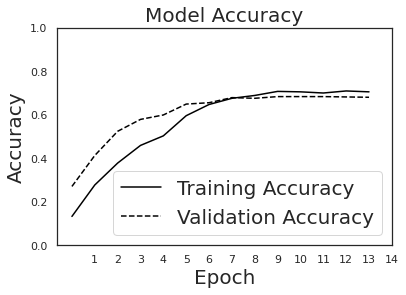

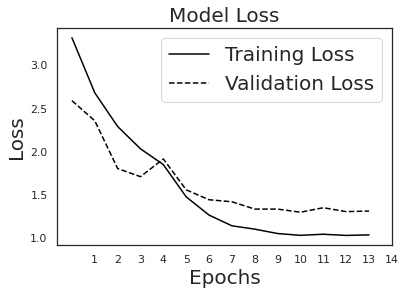

In [17]:
# Accuracy and Loss 

from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sns.set()
sns.set_style(style='white')

# Accuracy vs epochs plot
def accuracy_plot(model, history):

    annot_size = 20
    fig_size = (10, 10)
    epochs = len(history.history['accuracy'])
    
    plt.plot(history.history['accuracy'], label='Training Accuracy', color='black')
    plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy', linestyle='dashed', color='black')
    
    plt.title('Model Accuracy', fontsize=annot_size)
    plt.xlabel('Epoch', fontsize=annot_size)
    plt.ylabel('Accuracy', fontsize=annot_size)
    plt.ylim([0, 1])
    plt.xticks(list(range(1, epochs+1)))
    plt.legend(loc='lower right', fontsize=annot_size)
    plt.savefig('accuracy.jpg', bbox_inches='tight')
    plt.show()

# Loss vs epochs plot
def loss_plot(model, history):
    annot_size = 20
    fig_size = (10, 10)
    epochs = len(history.history['loss'])
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.plot(loss, label='Training Loss', color='black')
    plt.plot(val_loss, label = 'Validation Loss', linestyle='dashed', color='black')
    
    plt.title('Model Loss', fontsize=annot_size)
    plt.xlabel('Epochs', fontsize=annot_size)
    plt.ylabel('Loss', fontsize=annot_size)
#     plt.ylim([0, 0.85])
    plt.xticks(list(range(1, epochs+1)))
    plt.legend(loc='upper right', fontsize=annot_size)
    plt.savefig('loss.jpg', bbox_inches='tight')
    plt.show()

accuracy_plot(model, history)
loss_plot(model, history)

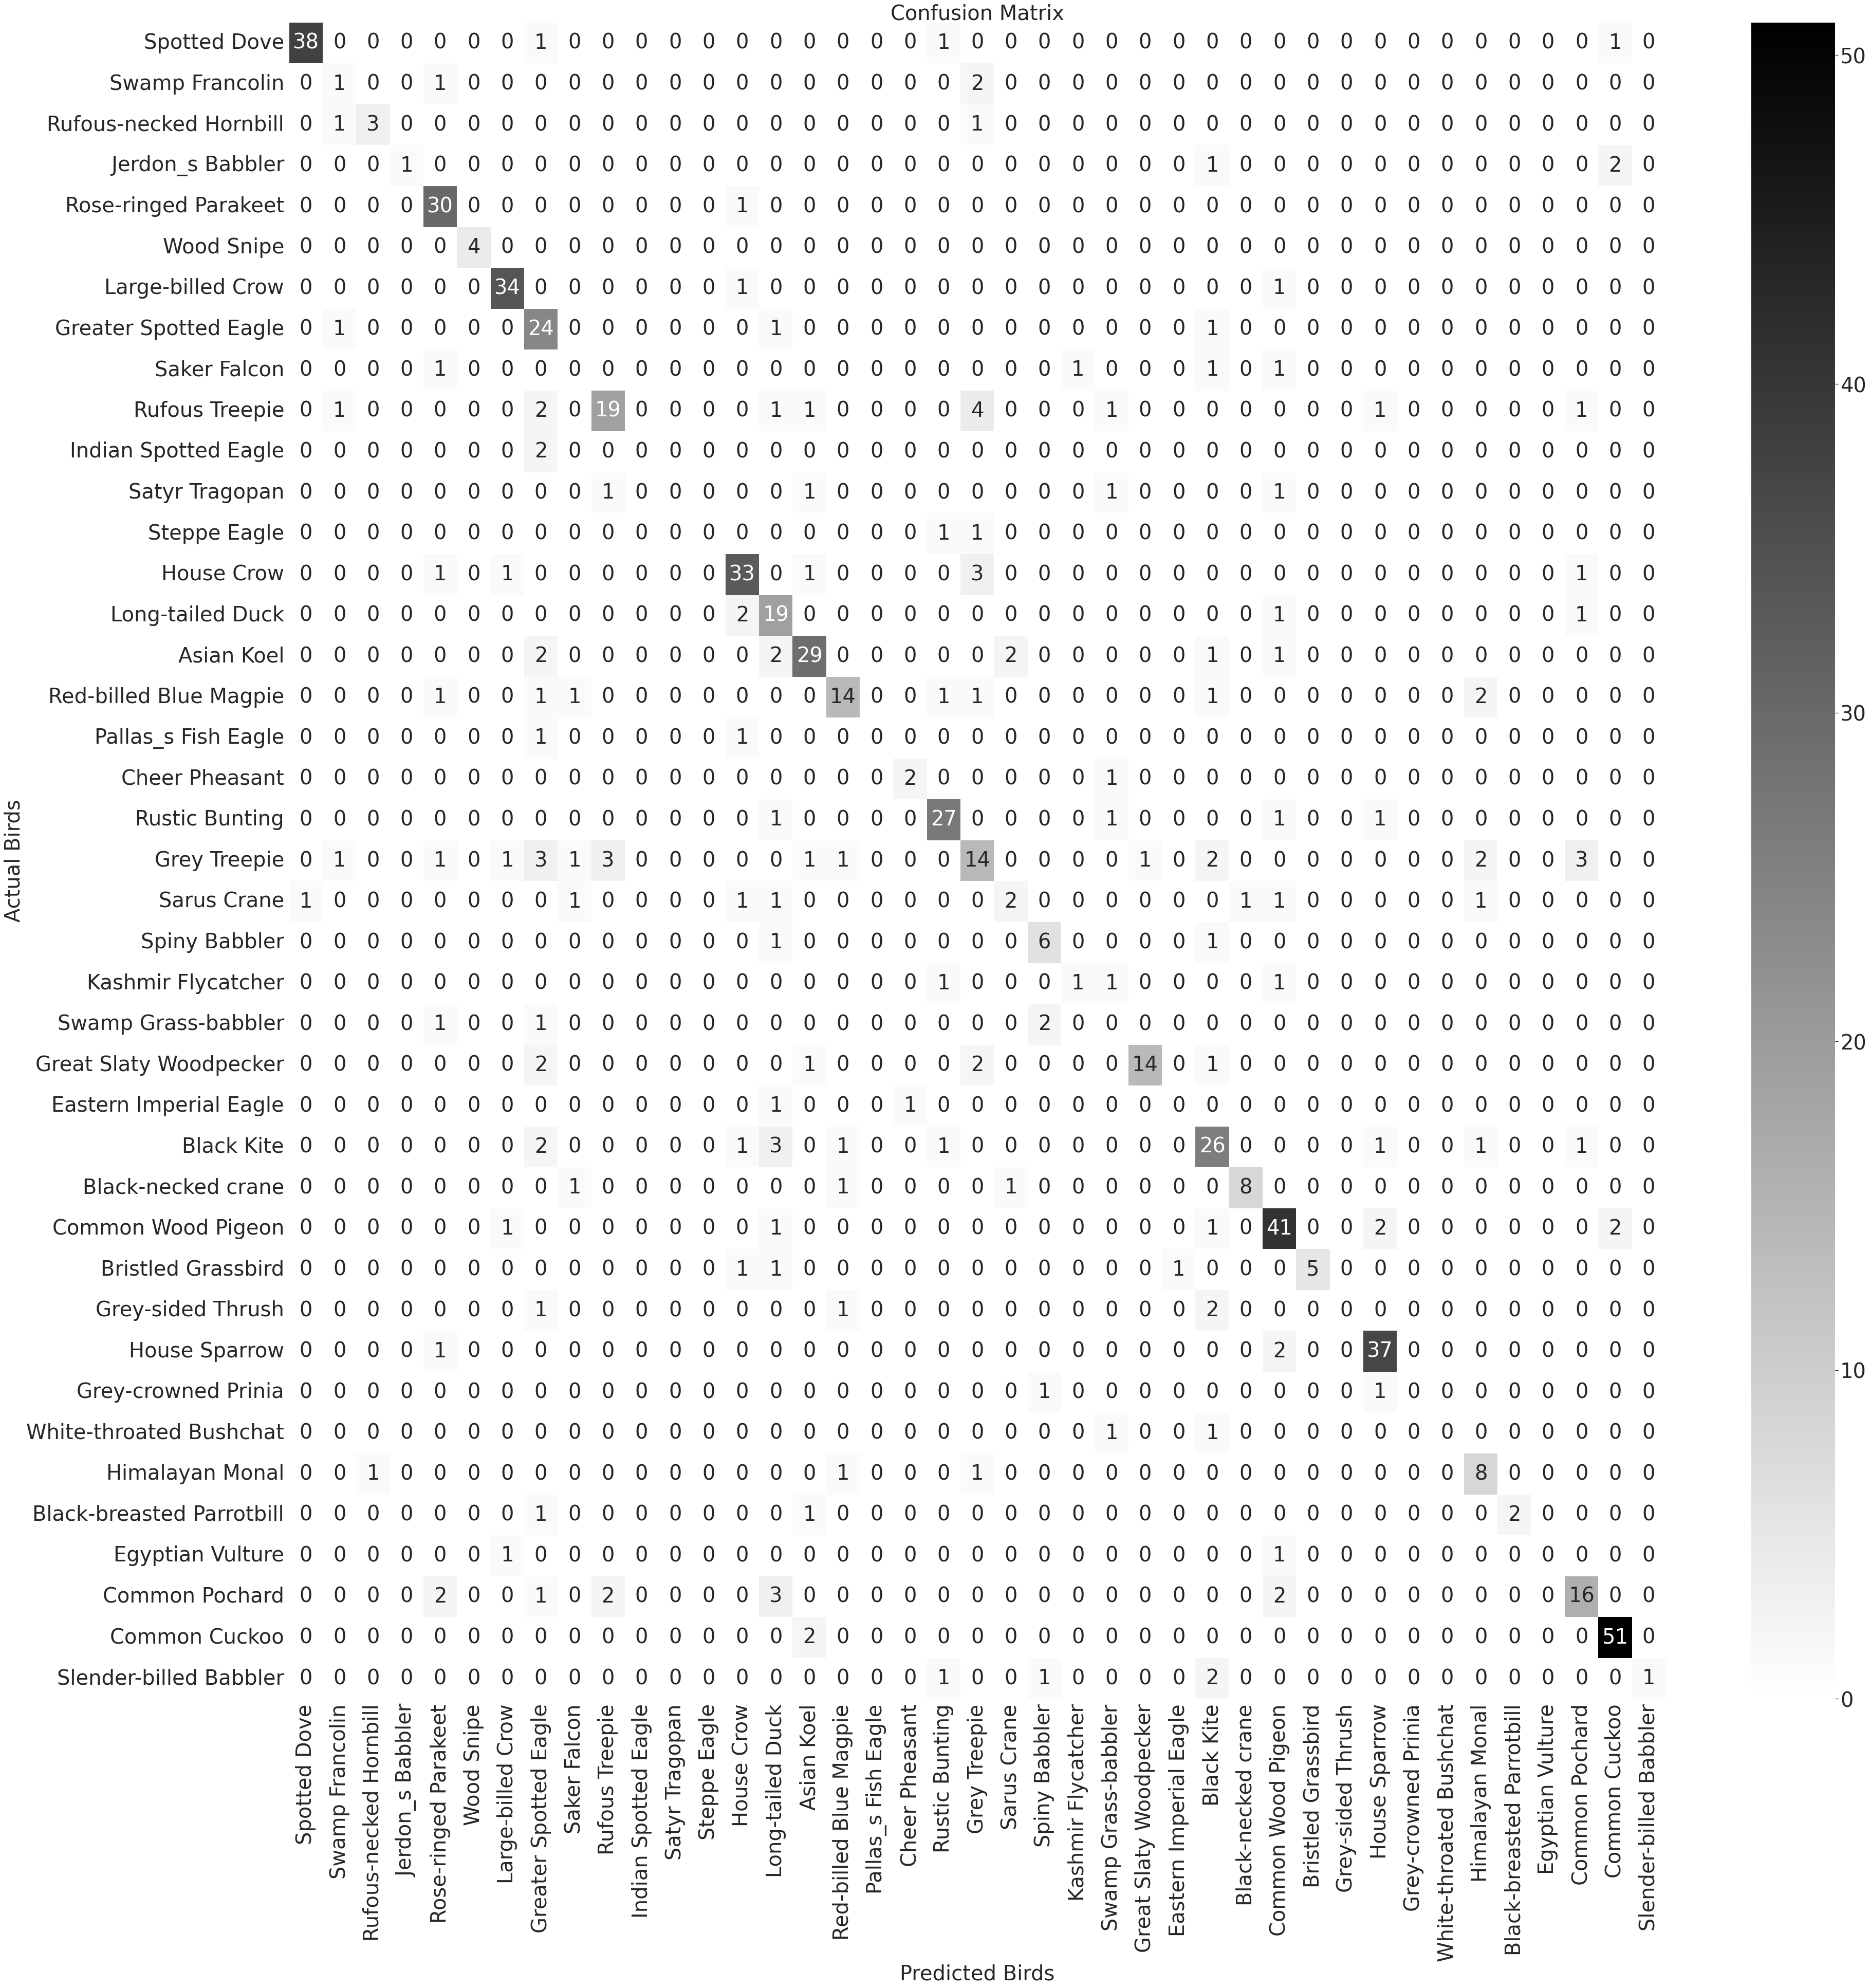

In [18]:
def confusion_matrix_plot(model, test_batches):
    
    annot_size = 40
    fig_size = (60, 60)

    preds = model.predict(x=test_batches)
    y_preds = np.argmax(preds, axis=-1)
    y_true = test_batches.classes

    confuse = confusion_matrix(y_true, y_preds)

    plt.rcParams["font.family"] = "Times New Roman"
    sns.set(rc = {'figure.figsize':fig_size, 'xtick.labelsize':annot_size, 'ytick.labelsize':annot_size})
    # plt.rcParams['figure.figsize'] = fig_size
    conf_df = pd.DataFrame(confuse)
    conf_df.index = BIRDS
    conf_df.columns = BIRDS
    sns.heatmap(conf_df, annot=True, cmap='binary', annot_kws={'size': annot_size})
    plt.title('Confusion Matrix', fontdict={'fontsize':annot_size}) 
    plt.xlabel('Predicted Birds', fontdict={'fontsize':annot_size})
    plt.ylabel('Actual Birds', fontdict={'fontsize':annot_size})
    plt.savefig('Confusion Matrix.png', dpi=200, format='png', bbox_inches='tight')

confusion_matrix_plot(model, test_batches)

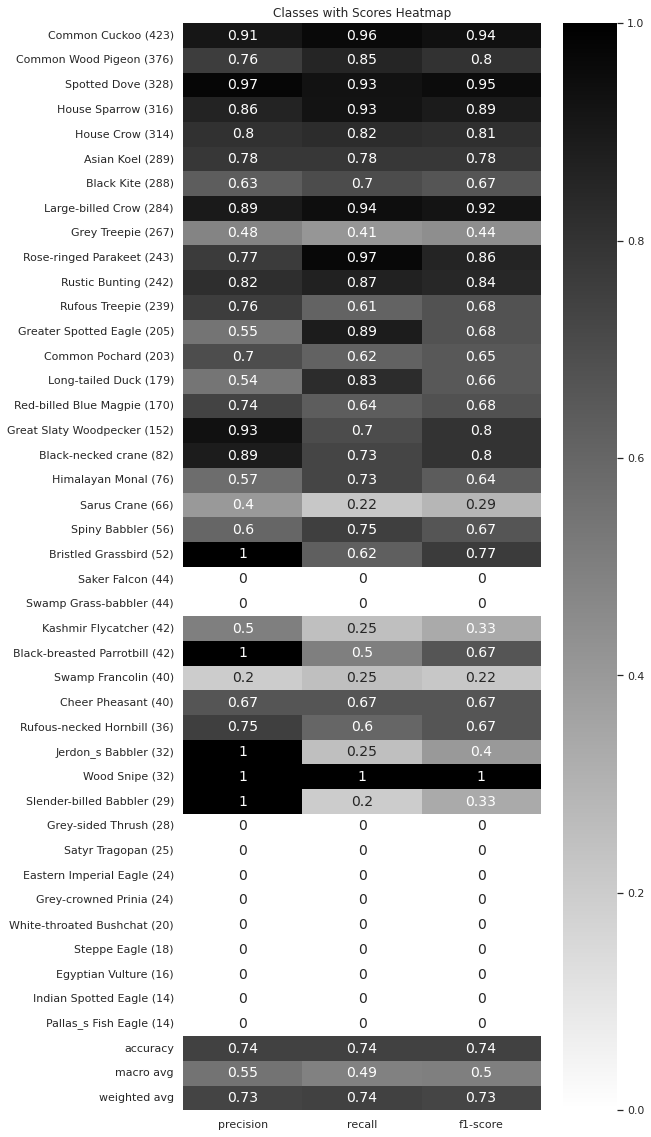

In [19]:
# Classes with scores heatmap

def class_scores(classes_dir, model, test_batches):
    
    birds_train_count = {}
    annot_size = 14
    fig_size = (8,20)
    
    for f in os.listdir(classes_dir):
        birds_train_count[f] = len(os.listdir(os.path.join(train_dir, f)))

    birds_train_count = dict(sorted(birds_train_count.items(), key= lambda x: x[1], reverse=True))

    preds = model.predict(x=test_batches)
    y_preds = np.argmax(preds, axis=-1)
    y_true = test_batches.classes
    clf_report = classification_report(y_true, y_preds, output_dict=True)
    cls_df = pd.DataFrame(clf_report).iloc[:-1, :].T
    acc_to_counts = [str(BIRDS.index(bird)) for bird in [k for k in birds_train_count.keys()]] + ['accuracy', 'macro avg', 'weighted avg']

    cls_df = cls_df.reindex(acc_to_counts)
    y_label = [f"{k} ({v})" for k, v in birds_train_count.items()] + ['accuracy', 'macro avg', 'weighted avg']
    cls_df.index = y_label

    sns.set(rc = {'figure.figsize':fig_size})
    sns.heatmap(cls_df, annot=True, annot_kws={'size': annot_size}, cmap='binary')
    plt.title('Classes with Scores Heatmap') 
    plt.savefig('Classes with Scores Heatmap.png', dpi=200, format='png', bbox_inches='tight')

train_dir = '/kaggle/input/charanetmfccsmall/MFCCRough/train'

class_scores(train_dir, model, test_batches)